In [ ]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
import psutil
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import mlflow
import mlflow.xgboost
import mlflow.keras
import tempfile
import os
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Cell 2: Set Paths and MLflow
TRAIN_CSV = r"D:\DEPI\CIS project\Train.csv"
TEST_CSV = r"D:\DEPI\CIS project\Test.csv"
SUB_CSV = r"D:\DEPI\CIS project\Submission.csv"
TRAIN_END = '2017-07-15'
VAL_END = '2017-08-15'
mlflow.set_tracking_uri("file:///D:/DEPI/CIS project/mlruns")
mlflow.set_experiment("Sales_Forecasting")


2025/05/12 00:32:49 INFO mlflow.tracking.fluent: Experiment with name 'Sales_Forecasting' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///D:/DEPI/CIS project/mlruns/713921815019208488', creation_time=1746999169511, experiment_id='713921815019208488', last_update_time=1746999169511, lifecycle_stage='active', name='Sales_Forecasting', tags={}>

In [11]:
# Cell 3: Load Data
with mlflow.start_run(run_name="Load_Data"):
    train = pd.read_csv(TRAIN_CSV)
    test = pd.read_csv(TEST_CSV)
    sub = pd.read_csv(SUB_CSV)
    train['date'] = pd.to_datetime(train['date'])
    test['date'] = pd.to_datetime(test['date'], format='%d-%m-%Y')
    train[['store_nbr', 'onpromotion']] = train[['store_nbr', 'onpromotion']].astype('int32')
    test[['store_nbr', 'onpromotion']] = test[['store_nbr', 'onpromotion']].astype('int32')
    train['sales'] = train['sales'].astype('float32')
    train.dropna(subset=['date'], inplace=True)
    test.dropna(subset=['date'], inplace=True)
    mlflow.log_param("train_rows", train.shape[0])
    mlflow.log_param("test_rows", test.shape[0])

In [12]:
# Cell 4: Prepare Data
with mlflow.start_run(run_name="Prepare_Data"):
    train['is_train'] = 1
    test['is_train'] = 0
    combined = pd.concat([train, test]).sort_values(['store_nbr', 'family', 'date'])
    agg_dict = {'sales': 'mean', 'onpromotion': 'sum', 'is_train': 'first', 'id': 'first'}
    combined = combined.groupby(['store_nbr', 'family', 'date']).agg(agg_dict).reset_index()
    combined = combined.astype({'store_nbr': 'int32', 'family': 'category', 'date': 'datetime64[ns]', 'sales': 'float32', 'onpromotion': 'int32', 'is_train': 'int8'})

In [13]:
# Cell 5: Handle Missing Values
with mlflow.start_run(run_name="Fill_Missing"):
    grouped = combined.groupby(['store_nbr', 'family'])
    processed_groups = []
    for (store_nbr, family), group in grouped:
        group['sales'] = group['sales'].ffill().fillna(0).astype('float32')
        group['onpromotion'] = group['onpromotion'].fillna(0).astype('int32')
        processed_groups.append(group)
    combined = pd.concat(processed_groups)

In [14]:
# Cell 6: Add Features
with mlflow.start_run(run_name="Add_Features"):
    combined['day'] = combined['date'].dt.day.astype('int8')
    combined['dow'] = combined['date'].dt.dayofweek.astype('int8')
    combined['month'] = combined['date'].dt.month.astype('int8')
    combined['year'] = combined['date'].dt.year.astype('int16')
    combined['sin_month'] = np.sin(2 * np.pi * combined['month'] / 12).astype('float32')
    lags = [7, 14]
    for lag in lags:
        combined[f'lag_{lag}'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(lag).astype('float32')
    combined['roll_mean_7'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(7, min_periods=1).mean().astype('float32')
    combined['store_nbr_encoded'] = LabelEncoder().fit_transform(combined['store_nbr']).astype('int8')
    combined['family_encoded'] = LabelEncoder().fit_transform(combined['family']).astype('int8')
    feature_cols = ['onpromotion', 'day', 'dow', 'month', 'year', 'sin_month', 'store_nbr_encoded', 'family_encoded', 'lag_7', 'lag_14', 'roll_mean_7']
    combined[feature_cols] = StandardScaler().fit_transform(combined[feature_cols].fillna(0)).astype('float32')

In [15]:
# Cell 7: Split Data
with mlflow.start_run(run_name="Split_Data"):
    train = combined[combined['is_train'] == 1]
    test = combined[combined['is_train'] == 0].drop(['sales'], axis=1)
    train_set = train[train['date'] <= TRAIN_END]
    val_set = train[(train['date'] > TRAIN_END) & (train['date'] <= VAL_END)]
    mlflow.log_param("train_set_rows", train_set.shape[0])
    mlflow.log_param("val_set_rows", val_set.shape[0])


XGBoost Metrics: RMSLE=0.7053, RMSE=266.1672, MAE=87.6526, MAPE=2988743936.0000


2025/05/12 01:04:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


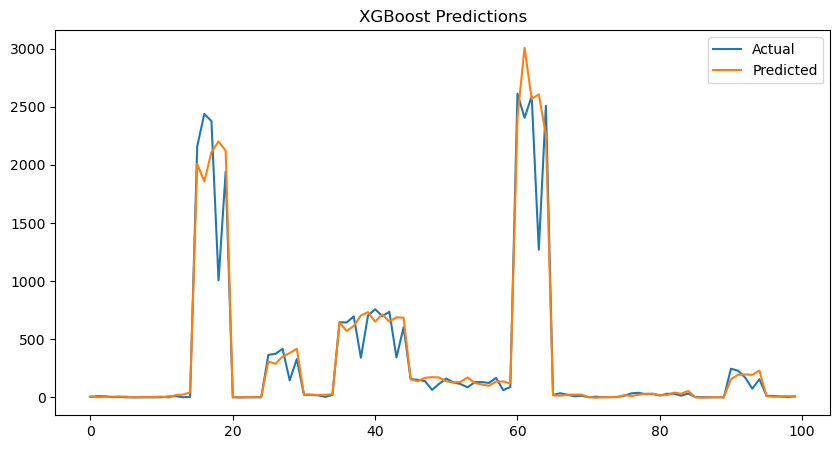

In [20]:
# Cell 8: Train XGBoost
with mlflow.start_run(run_name="XGBoost"):
    X_train = train_set[feature_cols]
    y_train = train_set['sales']
    X_val = val_set[feature_cols]
    y_val = val_set['sales']
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    actual = np.clip(y_val, 0, None)
    predicted = np.clip(y_pred, 0, None)
    metrics = {
        'rmsle': np.sqrt(mean_squared_error(np.log1p(actual), np.log1p(predicted))),
        'rmse': np.sqrt(mean_squared_error(actual, predicted)),
        'mae': mean_absolute_error(actual, predicted),
        'mape': mean_absolute_percentage_error(actual + 1e-10, predicted + 1e-10)
    }
    mlflow.log_metrics(metrics)
    print(f"XGBoost Metrics: RMSLE={metrics['rmsle']:.4f}, RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}, MAPE={metrics['mape']:.4f}")
    test['sales'] = model.predict(test[feature_cols])
    submission = test[['id', 'sales']].merge(sub[['id']], on='id', how='right').fillna({'sales': 0}).clip(lower=0)
    sub_path = os.path.join(tempfile.gettempdir(), "submission_xgboost.csv")
    submission.to_csv(sub_path, index=False)
    mlflow.log_artifact(sub_path)
    mlflow.xgboost.log_model(model, "xgboost_model")
    plt.figure(figsize=(10, 5))
    plt.plot(y_val.values[:100], label='Actual')
    plt.plot(y_pred[:100], label='Predicted')
    plt.title("XGBoost Predictions")
    plt.legend()
    plot_path = os.path.join(tempfile.gettempdir(), "xgb_pred.png")
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

In [ ]:
# Cell 9: Train ARIMA
with mlflow.start_run(run_name="ARIMA"):
    val_dates = pd.date_range('2017-07-16', '2017-08-15')
    test_dates = pd.date_range('2017-08-16', '2017-08-31')
    val_steps = len(val_dates)
    test_steps = len(test_dates)
    arima_preds = {}
    for (store, family), group in train_set.groupby(['store_nbr', 'family']):
        model = auto_arima(group['sales'], seasonal=False, max_p=3, max_q=3, trace=False)
        arima_preds[(store, family)] = model.predict(val_steps)
    actuals = []
    preds = []
    for (store, family), group in val_set.groupby(['store_nbr', 'family']):
        actuals.extend(group['sales'].values)
        preds.extend(arima_preds[(store, family)])
    actual = np.clip(actuals, 0, None)
    predicted = np.clip(preds, 0, None)
    metrics = {
        'rmsle': np.sqrt(mean_squared_error(np.log1p(actual), np.log1p(predicted))),
        'rmse': np.sqrt(mean_squared_error(actual, predicted)),
        'mae': mean_absolute_error(actual, predicted),
        'mape': mean_absolute_percentage_error(actual + 1e-10, predicted + 1e-10)
    }
    mlflow.log_metrics(metrics)
    print(f"ARIMA Metrics: RMSLE={metrics['rmsle']:.4f}, RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}, MAPE={metrics['mape']:.4f}")
    test_preds = {}
    for (store, family), group in train_set.groupby(['store_nbr', 'family']):
        model = auto_arima(group['sales'], seasonal=False, max_p=3, max_q=3, trace=False)
        test_preds[(store, family)] = model.predict(test_steps)
    test_copy = test.copy()
    for (store, family), pred_values in test_preds.items():
        mask = (test_copy['store_nbr'] == store) & (test_copy['family'] == family)
        test_copy.loc[mask, 'sales'] = pred_values[:mask.sum()]
    submission = test_copy[['id', 'sales']].merge(sub[['id']], on='id', how='right').fillna({'sales': 0}).clip(lower=0)
    sub_path = os.path.join(tempfile.gettempdir(), "submission_arima.csv")
    submission.to_csv(sub_path, index=False)
    mlflow.log_artifact(sub_path)
    plt.figure(figsize=(10, 5))
    plt.plot(actuals[:100], label='Actual')
    plt.plot(preds[:100], label='Predicted')
    plt.title("ARIMA Predictions")
    plt.legend()
    plot_path = os.path.join(tempfile.gettempdir(), "arima_pred.png")
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

In [ ]:
# Cell 10: Train SARIMA
with mlflow.start_run(run_name="SARIMA"):
    sarima_preds = {}
    for (store, family), group in train_set.groupby(['store_nbr', 'family']):
        model = auto_arima(group['sales'], seasonal=True, m=7, max_p=3, max_q=3, trace=False)
        sarima_preds[(store, family)] = model.predict(val_steps)
    actuals = []
    preds = []
    for (store, family), group in val_set.groupby(['store_nbr', 'family']):
        actuals.extend(group['sales'].values)
        preds.extend(sarima_preds[(store, family)])
    actual = np.clip(actuals, 0, None)
    predicted = np.clip(preds, 0, None)
    metrics = {
        'rmsle': np.sqrt(mean_squared_error(np.log1p(actual), np.log1p(predicted))),
        'rmse': np.sqrt(mean_squared_error(actual, predicted)),
        'mae': mean_absolute_error(actual, predicted),
        'mape': mean_absolute_percentage_error(actual + 1e-10, predicted + 1e-10)
    }
    mlflow.log_metrics(metrics)
    print(f"SARIMA Metrics: RMSLE={metrics['rmsle']:.4f}, RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}, MAPE={metrics['mape']:.4f}")
    test_preds = {}
    for (store, family), group in train_set.groupby(['store_nbr', 'family']):
        model = auto_arima(group['sales'], seasonal=True, m=7, max_p=3, max_q=3, trace=False)
        test_preds[(store, family)] = model.predict(test_steps)
    test_copy = test.copy()
    for (store, family), pred_values in test_preds.items():
        mask = (test_copy['store_nbr'] == store) & (test_copy['family'] == family)
        test_copy.loc[mask, 'sales'] = pred_values[:mask.sum()]
    submission = test_copy[['id', 'sales']].merge(sub[['id']], on='id', how='right').fillna({'sales': 0}).clip(lower=0)
    sub_path = os.path.join(tempfile.gettempdir(), "submission_sarima.csv")
    submission.to_csv(sub_path, index=False)
    mlflow.log_artifact(sub_path)
    plt.figure(figsize=(10, 5))
    plt.plot(actuals[:100], label='Actual')
    plt.plot(preds[:100], label='Predicted')
    plt.title("SARIMA Predictions")
    plt.legend()
    plot_path = os.path.join(tempfile.gettempdir(), "sarima_pred.png")
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)


In [ ]:
# Cell 11: Train Prophet
with mlflow.start_run(run_name="Prophet"):
    prophet_preds = {}
    for (store, family), group in train_set.groupby(['store_nbr', 'family']):
        df = group[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})
        model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
        model.fit(df)
        prophet_preds[(store, family)] = model.predict(pd.DataFrame({'ds': val_dates}))['yhat'].values
    actuals = []
    preds = []
    for (store, family), group in val_set.groupby(['store_nbr', 'family']):
        actuals.extend(group['sales'].values)
        preds.extend(prophet_preds[(store, family)])
    actual = np.clip(actuals, 0, None)
    predicted = np.clip(preds, 0, None)
    metrics = {
        'rmsle': np.sqrt(mean_squared_error(np.log1p(actual), np.log1p(predicted))),
        'rmse': np.sqrt(mean_squared_error(actual, predicted)),
        'mae': mean_absolute_error(actual, predicted),
        'mape': mean_absolute_percentage_error(actual + 1e-10, predicted + 1e-10)
    }
    mlflow.log_metrics(metrics)
    print(f"Prophet Metrics: RMSLE={metrics['rmsle']:.4f}, RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}, MAPE={metrics['mape']:.4f}")
    test_preds = {}
    for (store, family), group in train_set.groupby(['store_nbr', 'family']):
        df = group[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})
        model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
        model.fit(df)
        test_preds[(store, family)] = model.predict(pd.DataFrame({'ds': test_dates}))['yhat'].values
    test_copy = test.copy()
    for (store, family), pred_values in test_preds.items():
        mask = (test_copy['store_nbr'] == store) & (test_copy['family'] == family)
        test_copy.loc[mask, 'sales'] = pred_values[:mask.sum()]
    submission = test_copy[['id', 'sales']].merge(sub[['id']], on='id', how='right').fillna({'sales': 0}).clip(lower=0)
    sub_path = os.path.join(tempfile.gettempdir(), "submission_prophet.csv")
    submission.to_csv(sub_path, index=False)
    mlflow.log_artifact(sub_path)
    plt.figure(figsize=(10, 5))
    plt.plot(actuals[:100], label='Actual')
    plt.plot(preds[:100], label='Predicted')
    plt.title("Prophet Predictions")
    plt.legend()
    plot_path = os.path.join(tempfile.gettempdir(), "prophet_pred.png")
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

In [ ]:
# Cell 12: Train LSTM
with mlflow.start_run(run_name="LSTM"):
    seq_length = 7
    X_train = []
    y_train = []
    for _, g in train_set.groupby(['store_nbr', 'family']):
        g = g.sort_values('date')
        for i in range(len(g) - seq_length):
            X_train.append(g.iloc[i:i+seq_length][feature_cols].values)
            y_train.append(g.iloc[i+seq_length]['sales'])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = []
    y_val = []
    for _, g in val_set.groupby(['store_nbr', 'family']):
        g = g.sort_values('date')
        for i in range(len(g) - seq_length):
            X_val.append(g.iloc[i:i+seq_length][feature_cols].values)
            y_val.append(g.iloc[i+seq_length]['sales'])
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    model = Sequential([LSTM(50, activation='relu', input_shape=(seq_length, len(feature_cols))), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=1)
    y_pred = model.predict(X_val).flatten()
    actual = np.clip(y_val, 0, None)
    predicted = np.clip(y_pred, 0, None)
    metrics = {
        'rmsle': np.sqrt(mean_squared_error(np.log1p(actual), np.log1p(predicted))),
        'rmse': np.sqrt(mean_squared_error(actual, predicted)),
        'mae': mean_absolute_error(actual, predicted),
        'mape': mean_absolute_percentage_error(actual + 1e-10, predicted + 1e-10)
    }
    mlflow.log_metrics(metrics)
    print(f"LSTM Metrics: RMSLE={metrics['rmsle']:.4f}, RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}, MAPE={metrics['mape']:.4f}")
    X_test = []
    for key in test.groupby(['store_nbr', 'family']).groups.keys():
        last_seq = train_set[train_set['store_nbr'] == key[0]][train_set['family'] == key[1]].tail(seq_length)[feature_cols].values
        X_test.append(last_seq)
    X_test = np.array(X_test)
    test_preds_raw = model.predict(X_test).flatten()
    test_preds = {}
    for i, key in enumerate(test.groupby(['store_nbr', 'family']).groups.keys()):
        group_size = len(test[test['store_nbr'] == key[0]][test['family'] == key[1]])
        test_preds[key] = np.full(group_size, test_preds_raw[i])
    test_copy = test.copy()
    for (store, family), pred_values in test_preds.items():
        mask = (test_copy['store_nbr'] == store) & (test_copy['family'] == family)
        test_copy.loc[mask, 'sales'] = pred_values[:mask.sum()]
    submission = test_copy[['id', 'sales']].merge(sub[['id']], on='id', how='right').fillna({'sales': 0}).clip(lower=0)
    sub_path = os.path.join(tempfile.gettempdir(), "submission_lstm.csv")
    submission.to_csv(sub_path, index=False)
    mlflow.log_artifact(sub_path)
    mlflow.keras.log_model(model, "lstm_model")
    plt.figure(figsize=(10, 5))
    plt.plot(y_val[:100], label='Actual')
    plt.plot(y_pred[:100], label='Predicted')
    plt.title("LSTM Predictions")
    plt.legend()
    plot_path = os.path.join(tempfile.gettempdir(), "lstm_pred.png")
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)


In [ ]:
# Cell 13: Time Series Analysis
with mlflow.start_run(run_name="Time_Series_Analysis"):
    store, family = 1, 'AUTOMOTIVE'
    ts = train_set[(train_set['store_nbr'] == store) & (train_set['family'] == family)]['sales']
    plt.figure(figsize=(10, 5))
    plt.plot(ts, label='Sales')
    plt.plot(ts.rolling(30).mean(), label='30-Day Mean', color='red')
    plt.plot(ts.rolling(30).std(), label='30-Day Std', color='black')
    plt.title(f"Sales: Store {store}, Family {family}")
    plt.legend()
    plot_path = os.path.join(tempfile.gettempdir(), "ts_stationarity.png")
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    result = adfuller(ts.dropna())
    mlflow.log_metric("adf_statistic", result[0])
    mlflow.log_metric("adf_pvalue", result[1])
    print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    ts_diff = ts.diff().dropna()
    plt.figure(figsize=(10, 5))
    plot_acf(ts_diff, lags=20)
    plt.title("ACF of Differenced Series")
    acf_path = os.path.join(tempfile.gettempdir(), "acf_plot.png")
    plt.savefig(acf_path)
    mlflow.log_artifact(acf_path)
    lagged = pd.DataFrame({'sales': ts})
    for lag in [7, 14]:
        lagged[f'lag_{lag}'] = ts.shift(lag)
    corr = lagged.corr()['sales'].drop('sales').to_dict()
    mlflow.log_metrics({f"lag_{lag}_corr": val for lag, val in corr.items()})
    print("Lagged Correlations:", corr)


In [ ]:
# Cell 14: Final Output
with mlflow.start_run(run_name="Final_Output"):
    mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2
    mlflow.log_metric("memory_usage_mb", mem)
    print(f"Memory usage: {mem:.2f} MB")
    print("Execution completed.")